# AOD

## langley calibration

### load calibration

In [1]:
import helpers

In [2]:
import atmPy.radiation.retrievals.langley_calibration as atmlc

In [3]:
p2fld = pl.Path('/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.langleys/v0.2/')
lt = atmlc.open_langleys(p2fld)
lt648 = lt
lt.plot_ranked(wl = 500)
lt.V0_simple

ValueError: must supply at least one object to concatenate

# look up table

In [291]:
fnlut = '/home/hagen/projecte/mfrsr2pwv/data/pwd_od_lut_648.nc'
ds_lut = xr.open_dataset(fnlut)
ds_lut.attrs.update({'path2file': fnlut})

sh: 1: getfattr: not found


# the product

In [292]:
import atmPy.radiation.retrievals.spectral_irradiance as atmspec
import atmPy.aerosols.physics.column_optical_properties as atmcop

In [293]:
reload(atmspec)

<module 'atmPy.radiation.retrievals.spectral_irradiance' from '/home/hagen/prog/atm-py/atmPy/radiation/retrievals/spectral_irradiance.py'>

In [311]:
def make_product(fn,
                 fnmet,
                 fnlut,
                 langley_calibration,
                 serial_no,
                 version):
    
    ds = xr.open_dataset(fn)
    dsmet = xr.open_dataset(fnmet)
    gdd = atmspec.CombinedGlobalDiffuseDirect(ds.copy())
    gdd.dataset['channel_wavelength'] = gdd.dataset.channel_wavelength.astype(float) #error in processing upstream, fix it in future versions!
    gdd = gdd.apply_calibration_langley(langley_calibration)
    
    ### Moving to direct
    dni = gdd.direct_normal_irradiation
    dni.verbose = True
    
    # met data
    dni.met_data = dsmet
    
    #lookuptable for precipitagble water
    dni.precipitable_water = fnlut
    
    # ozone
    # dni.ozone_data = 300
    ozone = dsmet.ozone.where(dsmet.ozone != -99.999)
    ozone = ozone.interpolate_na('time', method = 'nearest', fill_value = 'extrapolate')
    dni.ozone_data = ozone
    
    # retrieve it all
    dni.raw_data.attrs['serial_no'] = serial_no #when looking for filters it will need the serial number
    dni.aod #this will trigger the retrieval and populate the raw_data
    
    # create cloud flag
    aod = atmcop.AOD_AOT(dni.raw_data)
    cm = aod.cloudmask.cloudmask_michalsky
    cm = cm.where(~ np.isnan(cm), 2).astype('int8')
    cm.attrs.update({
        "long_name": "cloud detection flag",
        "standard_name": "status_flag",
        "units": "1",
        "flag_values": '0, 1, 2',
        "flag_meanings": "no_cloud_detected cloud_detected algorithm_not_run",
        "description": (
            "0 = no cloud detected; 1 = cloud detected; "
            "2 = algorithm could not be evaluated"
        ),
    })
    dni.raw_data['cloud_flag'] = cm
    
    # format the file
    drop = ['alltime','toa_spectral_irradiance','ozone_absorption_spectrum', 'ozon_absoption_by_channel', 'wavelength', 'direct_horizontal']
    prod = dni.raw_data.drop_vars(drop)
    od1625 = dni.od_co2_ch4_h2o.sel(channel = 1625, drop = True)
    prod['od_1625nm_co2'] = od1625.co2
    prod['od_1625nm_ch4'] = od1625.ch4
    prod['od_1625nm_h2o'] = od1625.h2o_5cm
    
       
    
    prod = prod[["aod",
                 "cloud_flag",
                "precipitable_water",
                "transmission",
                "global_horizontal",
                "diffuse_horizontal",
                "direct_normal",
                "od_rayleigh",
                "od_ozone",
                "od_1625nm_co2",
                "od_1625nm_ch4",
                "od_1625nm_h2o",
                "channel_wavelength",
                "cosine_calibraion_direct",
                "solar_zenith_angle",
                "solar_azimuth_angle",
                "pressure",
                "temperature",
                "ozone_data",]]
    
    # add some attributes
    attrs = dict(description = 'Spectral AOD, downwelling fluxes, and precipitable water from NOAA/GRAD MFRSR instruments during 2025 FRC in Davos',
                site_longitude = f'{360 + prod.attrs['site_longitude']:0.6f}',
                site_latitude = f'{prod.attrs['site_latitude']:0.6f}',
                 serial_no = prod.attrs['serial_no'],
                 instrument_type = prod.attrs['instrument_type'],
                 input_files = ', '.join([fn.as_posix(), fnmet.as_posix(), fnlut.attrs['path2file']]),
                 processing_timestamp = f'{pd.Timestamp.now()}',
                 product_version = version
                )          
    
    prod.attrs = attrs
    out = {'product': prod, 'dni_inst': dni}
    return out

In [295]:
# Test
out = make_product(fn = pl.Path('/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.cal/v0.1/frc_648_v0.1_20250929.nc'),
                 fnmet = pl.Path('/nfs/grad/campaign/frc/2025/MetaData.netcdf/frc-vi_metadata_20250929_preliminary.nc'),
                 fnlut =  ds_lut,
                 langley_calibration = lt648,
                 serial_no = 648,
                 version = 0.1)

sh: 1: getfattr: not found
sh: 1: getfattr: not found
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/pysolar/solartime.py:113: UserWarning: I don't know about leap seconds after 2023
  warnings.warn \
/home/hagen/prog/atm-py/atmPy/radiation/solar.py:125: UserWarning: Discarding nonzero nanoseconds in conversion.
  date = date.to_pydatetime()
sh: 1: getfattr: not found
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/pysolar/solartime.py:113: UserWarning: I don't know about leap seconds after 2023
  warnings.warn \
/home/hagen/prog/atm-py/atmPy/radiation/sol

whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/xarray/core/missing.py:588: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x_loaded)
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/xarray/core/missing.py:589: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x_loaded)


Retrieving precipitable water from 940nm channel using lookup table.


In [296]:
dni = out['dni_inst']

In [297]:
prod = out['product']

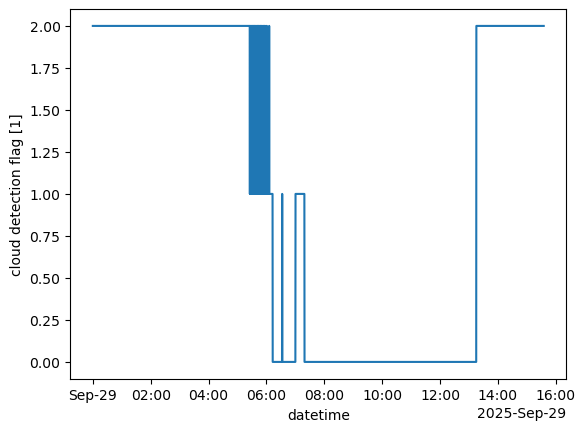

In [298]:
prod.cloud_flag.plot()

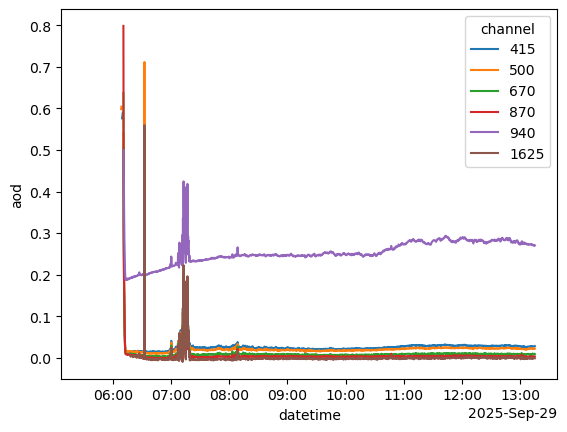

In [299]:
prod.aod.plot.line(x = 'datetime')

# Workplan

In [300]:
version = '0.1'
serial_no = 648
p2fld_out = pl.Path(f'/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/netcdf/v{version}/')
p2fld_mfrsr = pl.Path(f'/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/{serial_no}.cal/v0.1/')
p2fld_met = pl.Path('/nfs/grad/campaign/frc/2025/MetaData.netcdf/')

In [301]:
dfmfrsr = pd.DataFrame(p2fld_mfrsr.glob('*.nc'), columns=['p2f_mfrsr_in'])
dfmfrsr.index = dfmfrsr.apply(lambda row: pd.to_datetime(row.p2f_mfrsr_in.name.split('_')[-1].replace('.nc','')), axis =1)

dfmet = pd.DataFrame(p2fld_met.glob('*.nc'), columns=['p2f_met'])
dfmet.index = dfmet.apply(lambda row: pd.to_datetime(row.p2f_met.name.split('_')[-2]), axis = 1)

mp = pd.concat([dfmfrsr,dfmet], axis = 1)
mp['p2f_out'] = mp.apply(lambda row: p2fld_out.joinpath(f'aod_frc_{serial_no}_v{version}_{row.name.strftime('%Y%m%d')}.nc'), axis = 1)

In [302]:
wp = mp.dropna()
wp = wp[~wp.apply(lambda row: row.p2f_out.exists(), axis = 1)]

In [303]:
wp

,p2f_mfrsr_in,p2f_met,p2f_out
2025-09-25,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-09-26,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-09-27,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-09-28,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-09-29,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-10-01,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-10-02,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-10-03,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-10-04,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-10-06,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...


# work it

In [314]:
import warnings
warnings.filterwarnings('ignore')

In [320]:
for idx, row in wp.iterrows():
    if row.p2f_out.exists():
        continue

    try:
        out = make_product(row.p2f_mfrsr_in, 
                           row.p2f_met, 
                           ds_lut,
                          lt648,
                          serial_no,
                          version)
        
        prod = out['product']
        row.p2f_out.parent.mkdir(parents=True)
        prod.to_netcdf(row.p2f_out)
    except:
        print('something went wrong')
        continue

sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found


Retrieving precipitable water from 940nm channel using lookup table.
something went wrong


In [321]:
wp[~wp.apply(lambda row: row.p2f_out.exists(), axis = 1)]

,p2f_mfrsr_in,p2f_met,p2f_out
2025-09-26,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-09-27,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-09-28,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-09-29,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-10-01,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-10-02,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-10-03,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-10-04,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-10-06,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...
2025-10-07,/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648...,/nfs/grad/campaign/frc/2025/MetaData.netcdf/fr...,/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/...


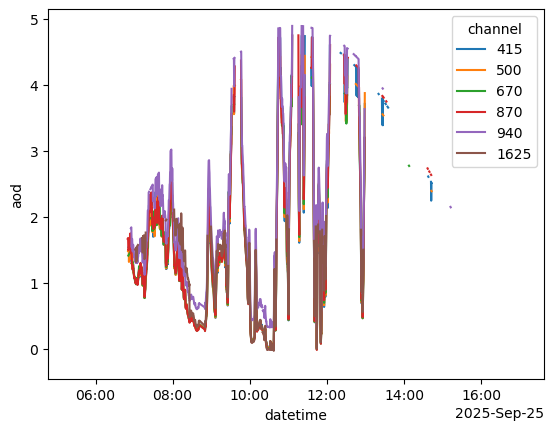

In [316]:
prod.aod.plot.line(x = 'datetime')

# OLD!!

sh: 1: getfattr: not found
sh: 1: getfattr: not found
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/pysolar/solartime.py:113: UserWarning: I don't know about leap seconds after 2023
  warnings.warn \
/home/hagen/prog/atm-py/atmPy/radiation/solar.py:125: UserWarning: Discarding nonzero nanoseconds in conversion.
  date = date.to_pydatetime()
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/pysolar/solartime.py:113: UserWarning: I don't know about leap seconds after 2023
  warni

whatup
Renaming time coordinate to datetime for ozone data.


sh: 1: getfattr: not found
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/xarray/core/missing.py:588: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x_loaded)
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/xarray/core/missing.py:589: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x_loaded)


Retrieving precipitable water from 940nm channel using lookup table.


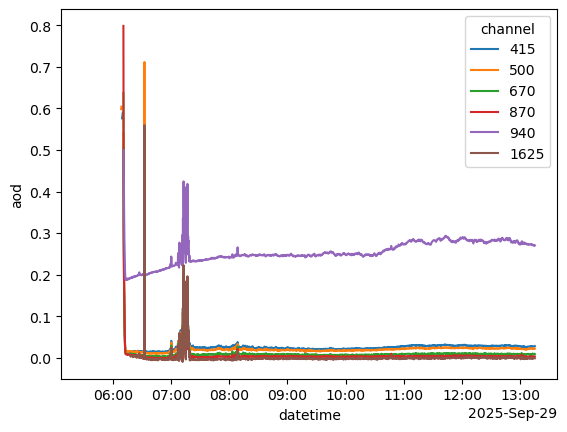

In [167]:
serial_no = 648
fn = '/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.cal/v0.1/frc_648_v0.1_20250929.nc'
fnmet = '/nfs/grad/campaign/frc/2025/MetaData.netcdf/frc-vi_metadata_20250929_preliminary.nc'
ds = xr.open_dataset(fn)
dsmet = xr.open_dataset(fnmet)
gdd = atmspec.CombinedGlobalDiffuseDirect(ds.copy())
gdd.dataset['channel_wavelength'] = gdd.dataset.channel_wavelength.astype(float) #error in processing upstream, fix it in future versions!
gdd = gdd.apply_calibration_langley(lt648)

dni = gdd.direct_normal_irradiation
dni.verbose = True
# dni.raw_data = dni.raw_data.where(dni.raw_data.channel < 1000, drop = True)
dni.met_data = dsmet
# dni.precipitable_water_varname = 'precipitable_water_aeronet'
fnlut = '/home/hagen/projecte/mfrsr2pwv/data/pwd_od_lut_648.nc'
dni.precipitable_water = fnlut

dni.met_data = fnmet
# dni.ozone_data = 300
ozone = dsmet.ozone.where(dsmet.ozone != -99.999)
ozone = ozone.interpolate_na('time', method = 'nearest', fill_value = 'extrapolate')
dni.ozone_data = ozone

dni.raw_data.attrs['serial_no'] = serial_no
# dni.mfrsr_history = None
dni.aod.plot.line(x = 'datetime')
dni648 = dni

# how is the product supposed to look like?

In [123]:
dni.raw_data

<xarray.Dataset> Size: 2MB
Dimensions:                    (datetime: 2806, channel: 6, wavelength: 596)
Coordinates:
  * datetime                   (datetime) datetime64[ns] 22kB 2025-09-29 ... ...
  * channel                    (channel) int64 48B 415 500 670 870 940 1625
  * wavelength                 (wavelength) int64 5kB 380 381 382 ... 974 975
Data variables: (12/20)
    alltime                    (datetime, channel) int64 135kB ...
    global_horizontal          (datetime, channel) float64 135kB nan ... 0.06159
    diffuse_horizontal         (datetime, channel) float64 135kB nan ... 0.00...
    channel_wavelength         (channel) float64 48B 413.6 497.1 ... 1.624e+03
    direct_horizontal          (datetime, channel) float64 135kB ...
    cosine_calibraion_direct   (datetime, channel) float64 135kB ...
    ...                         ...
    od_rayleigh                (channel, datetime) float64 135kB 0.26 ... nan
    aod                        (datetime, channel) float64 135kB nan nan ... nan
    precipitable_water         (datetime) float64 22kB nan nan nan ... nan nan
    ozone_absorption_spectrum  (wavelength) float64 5kB 0.0 0.0 0.0 ... 0.0 0.0
    ozon_absoption_by_channel  (channel) float64 48B 0.0003 0.02579 ... 0.0
    od_ozone                   (channel, datetime) float64 135kB 8.805e-05 .....
Attributes: (12/18)
    site_longitude:         -350.161743
    site_latitude:          46.807251
    site_elevation:         0
    site:                   TMP
    site_name:              unknown
    calibrated_irradiance:  False
    ...                     ...
    day_complete:           False
    parent_files:           /nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648/64...
    product_version:        0.1
    calibrated_spectral:    True
    clalibration_cosine:    True
    calibrated_langley:     True

In [126]:
drop = ['alltime','toa_spectral_irradiance','ozone_absorption_spectrum', 'ozon_absoption_by_channel', 'wavelength', 'direct_horizontal']
prod = dni.raw_data.drop_vars(drop)
od1625 = dni.od_co2_ch4_h2o.sel(channel = 1625, drop = True)
prod['od_1625nm_co2'] = od1625.co2
prod['od_1625nm_ch4'] = od1625.ch4
prod['od_1625nm_h2o'] = od1625.h2o_5cm

<xarray.Dataset> Size: 1MB
Dimensions:                   (datetime: 2806, channel: 6)
Coordinates:
  * datetime                  (datetime) datetime64[ns] 22kB 2025-09-29 ... 2...
  * channel                   (channel) int64 48B 415 500 670 870 940 1625
Data variables: (12/16)
    global_horizontal         (datetime, channel) float64 135kB nan ... 0.06159
    diffuse_horizontal        (datetime, channel) float64 135kB nan ... 0.004317
    channel_wavelength        (channel) float64 48B 413.6 497.1 ... 1.624e+03
    direct_horizontal         (datetime, channel) float64 135kB ...
    cosine_calibraion_direct  (datetime, channel) float64 135kB ...
    solar_zenith_angle        (datetime) float64 22kB ...
    ...                        ...
    ozone_data                (datetime) float64 22kB 293.5 293.5 ... 298.2
    transmission              (datetime, channel) float64 135kB nan ... 0.9755
    od_rayleigh               (channel, datetime) float64 135kB 0.26 ... nan
    aod                       (datetime, channel) float64 135kB nan nan ... nan
    precipitable_water        (datetime) float64 22kB nan nan nan ... nan nan
    od_ozone                  (channel, datetime) float64 135kB 8.805e-05 ......
Attributes: (12/18)
    site_longitude:         -350.161743
    site_latitude:          46.807251
    site_elevation:         0
    site:                   TMP
    site_name:              unknown
    calibrated_irradiance:  False
    ...                     ...
    day_complete:           False
    parent_files:           /nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648/64...
    product_version:        0.1
    calibrated_spectral:    True
    clalibration_cosine:    True
    calibrated_langley:     True

In [143]:
prod = prod[["aod",
"precipitable_water",
"transmission",
"global_horizontal",
"diffuse_horizontal",
"direct_normal",
"od_rayleigh",
"od_ozone",
"od_1625nm_co2",
"od_1625nm_ch4",
"od_1625nm_h2o",
"channel_wavelength",
"cosine_calibraion_direct",
"solar_zenith_angle",
"solar_azimuth_angle",
"pressure",
"temperature",
"ozone_data",]]

In [144]:
prod

<xarray.Dataset> Size: 1MB
Dimensions:                   (datetime: 2806, channel: 6)
Coordinates:
  * datetime                  (datetime) datetime64[ns] 22kB 2025-09-29 ... 2...
  * channel                   (channel) int64 48B 415 500 670 870 940 1625
Data variables: (12/18)
    aod                       (datetime, channel) float64 135kB nan nan ... nan
    precipitable_water        (datetime) float64 22kB nan nan nan ... nan nan
    transmission              (datetime, channel) float64 135kB nan ... 0.9755
    global_horizontal         (datetime, channel) float64 135kB nan ... 0.06159
    diffuse_horizontal        (datetime, channel) float64 135kB nan ... 0.004317
    direct_normal             (datetime, channel) float64 135kB nan ... 0.2342
    ...                        ...
    cosine_calibraion_direct  (datetime, channel) float64 135kB ...
    solar_zenith_angle        (datetime) float64 22kB ...
    solar_azimuth_angle       (datetime) float64 22kB ...
    pressure                  (datetime) float64 22kB 844.9 844.9 ... nan nan
    temperature               (datetime) float64 22kB nan nan nan ... nan nan
    ozone_data                (datetime) float64 22kB 293.5 293.5 ... 298.2
Attributes: (12/18)
    site_longitude:         -350.161743
    site_latitude:          46.807251
    site_elevation:         0
    site:                   TMP
    site_name:              unknown
    calibrated_irradiance:  False
    ...                     ...
    day_complete:           False
    parent_files:           /nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648/64...
    product_version:        0.1
    calibrated_spectral:    True
    clalibration_cosine:    True
    calibrated_langley:     True

In [153]:
attrs = dict(description = 'Spectral AOD, downwelling fluxes, and precipitable water from NOAA/GRAD MFRSR instruments during 2025 FRC in Davos',
            site_longitude = f'{360 + prod.attrs['site_longitude']:0.6f}',
            site_latitude = f'{prod.attrs['site_latitude']:0.6f}',
             serial_no = prod.attrs['serial_no'],
             instrument_type = prod.attrs['instrument_type'],
             input_files = ', '.join([fn, fnmet, fnlut]),
             processing_timestamp = f'{pd.Timestamp.now()}'
            )
attrs
            

{'description': 'Spectral AOD, downwelling fluxes, and precipitable water from NOAA/GRAD MFRSR instruments during 2025 FRC in Davos',
 'site_longitude': '9.838257',
 'site_latitude': '46.807251',
 'serial_no': 648,
 'instrument_type': 'mfrsr',
 'input_files': '/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.cal/v0.1/frc_648_v0.1_20250929.nc, /nfs/grad/campaign/frc/2025/MetaData.netcdf/frc-vi_metadata_20250929_preliminary.nc, /home/hagen/projecte/mfrsr2pwv/data/pwd_od_lut_648.nc',
 'processing_timestamp': '2025-11-17 17:08:22.614672'}

In [154]:
prod.attrs = attrs